In [1]:
# !pip install onnx2torch

In [2]:
import os, time
import insightface, torch, onnxruntime, cv2
import numpy as np
from insightface.app.common import Face
from PIL import Image
import requests
import torch
import torchvision
import matplotlib.pyplot as plt
from modules.controlnet import IdentityFilter, BaseFilter
from train_c_controlnet import WurstCore
import time
import yaml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# SETUP WARPCORE
config_file = 'configs/controlnet_c_3b_identity.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 4
    
    # Humans 7M
    loaded_config['captions_getter']  = ['generated_txt', 'identity']
    loaded_config['webdataset_path'] = 'pipe:aws s3 cp s3://laion-west/humans-7M-with-blip-caps+aesthetics+nsfw/00000{1..5499}.tar -'

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device
)

>>> RESUMING TRAINING FROM ITER  9000


In [8]:
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)

Training with batch size 4 (4/GPU)


In [9]:
controlnet_filter = IdentityFilter(device, max_faces=4, p_drop=0.0, p_full=0.0) # , p_drop=0.05, p_full=0.5)

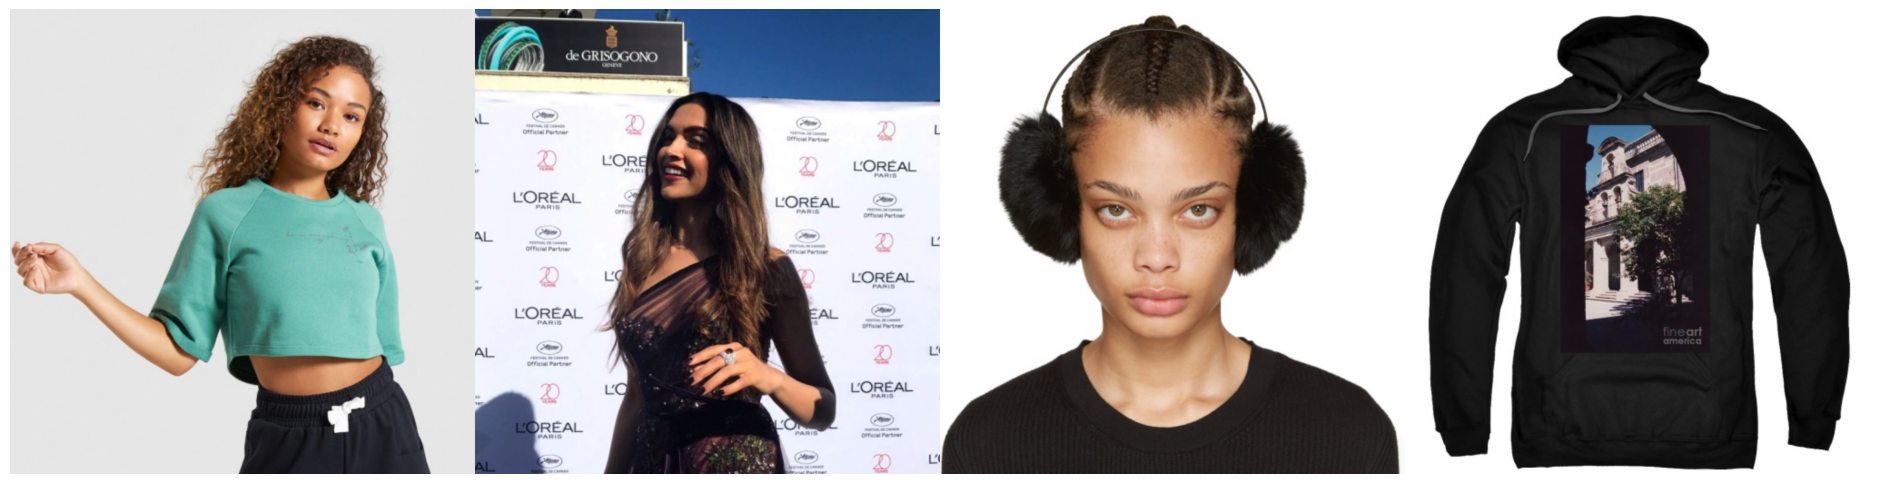

['The Nike cropped sweatshirt is shown in green.', 'The beautiful actress is posing for pictures.', "The black ear muffs are worn to make it look like they're wearing fur.", 'An old building with trees in front and sweatshirt.']


In [13]:
# urls = [
#     "https://cdn.discordapp.com/attachments/1198177251238363219/1198309860756963468/brad-pitt-attends-the-premiere-of-20th-century-foxs--square.jpg?ex=65be7006&is=65abfb06&hm=2c9632a1d37ad9e776dad0db96966ade519e25ad6c7dde00793b01af0f0836f6&", # BRAD PITT
#     "https://static.ffx.io/images/$zoom_1.444%2C$multiply_0.7725%2C$ratio_1.5%2C$width_756%2C$x_70%2C$y_0/t_crop_custom/q_86%2Cf_auto/6ca4ae8917e05b81290f3b20b984f93d11e2ddc6", # FAMOUS PEOPLE
#     "https://res.cloudinary.com/ybmedia/image/upload/c_crop,h_1123,w_2000,x_0,y_0/c_fill,f_auto,h_1215,q_auto,w_2160/v1/m/4/b/4b4e8a03ce096567ccf8f2a9283c224f85fe6f89/famous-foursomes-pop-culture.jpg",
# #     "https://qph.cf2.quoracdn.net/main-qimg-d0861bad092a1512204d64615e2c66bb-pjlq",
#     "https://cdn.discordapp.com/attachments/1039261364935462942/1198425943404986578/5cc9adc10b83cd4e275bf2b69207e665.png?ex=65bedc22&is=65ac6722&hm=97f89e7bc1112fd080ce1400908bb47ce6e3fc4d05a84b6c5716a60146f1c461&",
# ]
# images = torch.stack([extras.transforms(Image.open(requests.get(url, stream=True).raw).convert("RGB")) for url in urls], dim=0).to(device)
batch = next(data.iterator)
images = batch['images']
# images = images.flip(dims=[-1])

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in images.clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'])


ELAPSED: 9.62s


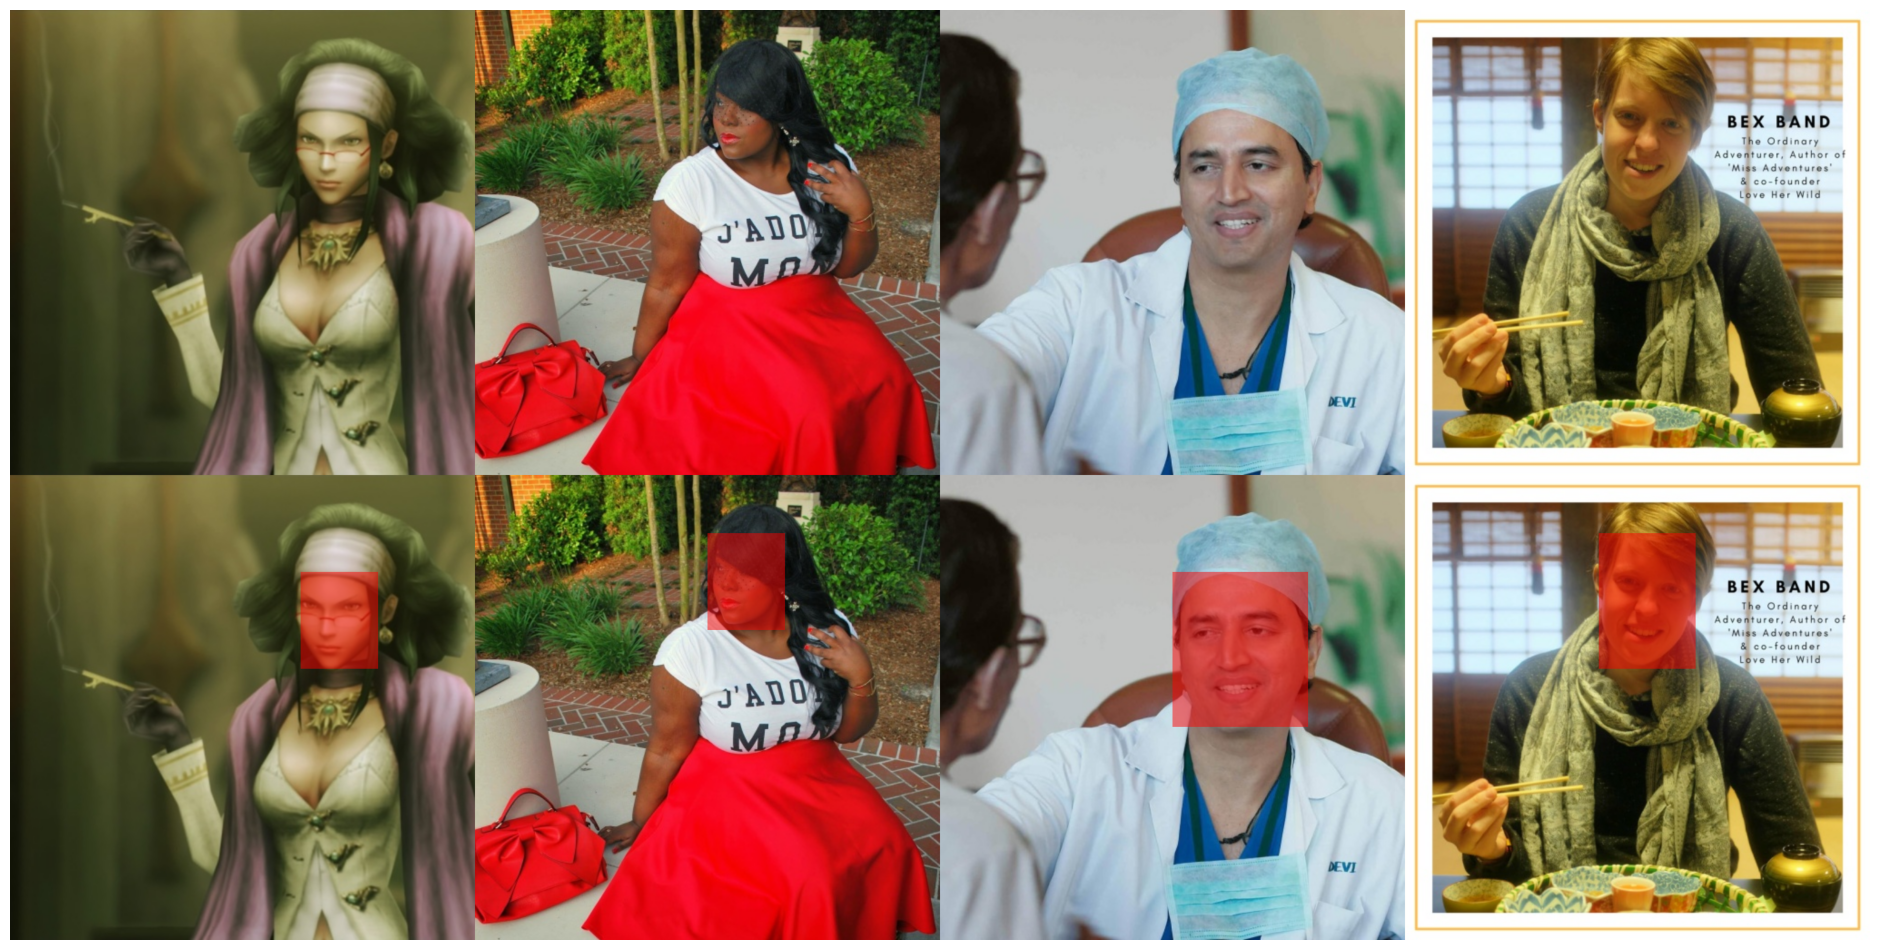

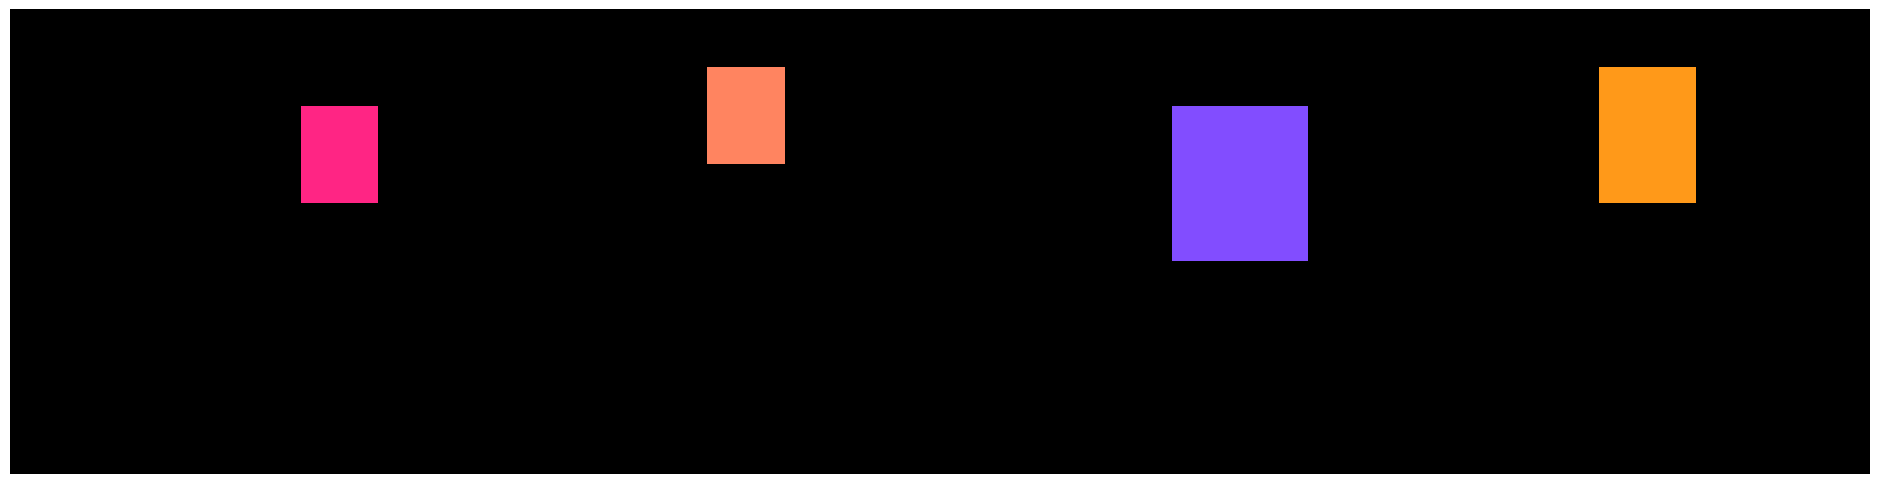

In [11]:
start_time = time.time()
cnet_input, cnet_input_preview = controlnet_filter(images)
print("ELAPSED:", f"{round(time.time()-start_time, 2)}s")
    
plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in images.cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in cnet_input_preview.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in (cnet_input[:, :3].abs() / cnet_input[:, :3].abs().amax(dim=[1, 2, 3], keepdim=True)).cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()
